# 1 - Setup

## 1.1 - Imports & Configs

In [1]:
from utils import *

## 1.2 - Constants & Globals

In [2]:
OUTPUT_CSV = "./output/csv/"
OUTPUT_GRAPH = "./output/graph/"
DF_CLEAN = pd.read_csv("./output/csv/data_clean.csv")
sns.set_theme(style="whitegrid")
plt.rcParams["patch.edgecolor"] = "none"
plt.rcParams["patch.linewidth"] = 0
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

# 2 - Visão Geral

In [3]:
df_work = DF_CLEAN.copy()

## 2.1 - Pergunta 13: Os profissionais da área de dados estão trabalhando em qual modalidade?
O modelo de trabalho mais comum entre os profissionais da área de dados neste dataset é o **100% Remoto**, com **50.5%**.<br>
<br>
*Excluidos entrevistados trabalhando nos cargos: "Outra Opção", "Outras Engenharias (não inclui dev)", "Professor/Pesquisador", "Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas" e "Economista".*

In [4]:
# Excluindo entrevistados que não estão trabalhando ou não responderam a pergunta
df_filtered = df_work[~df_work["P2_a Qual sua situação atual de trabalho?"].isin([
    "Desempregado, buscando recolocação",
    "Desempregado e não estou buscando recolocação",
    "Prefiro não informar"
])]
# Selecionando as colunas de interesse, agrupando por modelo de trabalho e cargo atual e somando a quantidade de entrevistados em cada grupo
df_by_work_model = df_filtered[["P0 id", "P2_a Qual sua situação atual de trabalho?", "P2_f Cargo Atual", "P2_r Atualmente qual a sua forma de trabalho?"]].groupby(["P2_r Atualmente qual a sua forma de trabalho?", "P2_f Cargo Atual"]).size().reset_index(name="count")


In [5]:
# Removendo entrevistados que não trabalham na área de dados, agrupando pelo modelo de trabalho e somando a quantidade de entrevistados em cada grupo
fig = df_by_work_model[~df_by_work_model["P2_f Cargo Atual"].isin([
    "Outra Opção",
    "Outras Engenharias (não inclui dev)",
    "Professor/Pesquisador",
    "Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas",
    "Economista"
])].groupby("P2_r Atualmente qual a sua forma de trabalho?").sum().reset_index()
fig = fig.drop(columns=["P2_f Cargo Atual"])
fig = fig.replace({"P2_r Atualmente qual a sua forma de trabalho?": {r"Modelo híbrido flexível.*": "Modelo híbrido flexível"}}, regex=True)
fig



,P2_r Atualmente qual a sua forma de trabalho?,count
0,Modelo 100% presencial,447
1,Modelo 100% remoto,1727
2,Modelo híbrido com dias fixos de trabalho pres...,568
3,Modelo híbrido flexível,680


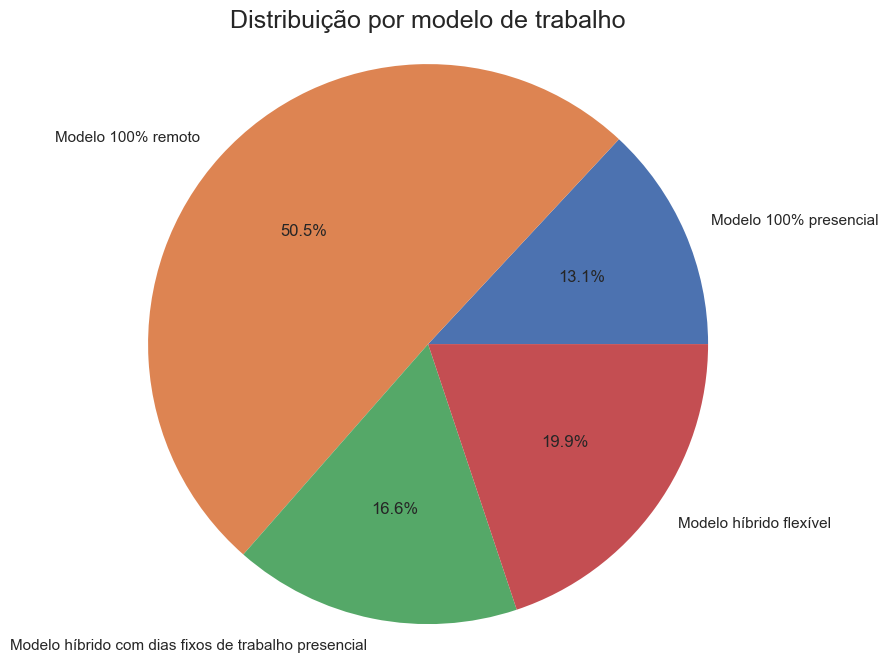

In [6]:
# Plotando o gráfico
plt.figure(figsize=(10, 8))
plt.pie(fig["count"], labels=fig["P2_r Atualmente qual a sua forma de trabalho?"], autopct="%1.1f%%")
plt.title("Distribuição por modelo de trabalho")
plt.axis("equal")
plt.savefig(OUTPUT_GRAPH+"pie_modelo_trabalho.png")
plt.show()

## 2.2 - Pergunta 3: Qual o nível de inglês predominante entre os profissionais mais experientes?
No dataset não há menções ao nível de inglês, porem, é possível inferir que entre os profissionais que trabalham para o mercado interno (Brasil) e mercado externo, o nível de experiencia é proporcionalmente maior para o mercado externo.

In [7]:
# Seleciona somente os entrevistados que trabalham para empresas estrangeiras
df_abroad = DF_CLEAN[DF_CLEAN["P2_a Qual sua situação atual de trabalho?"].isin(["Vivo fora do Brasil e trabalho para empresa de fora do Brasil", "Vivo no Brasil e trabalho para empresa de fora do Brasil"])]
df_abroad.shape

(64, 279)

In [8]:
# Criando df com a quantidade de pessoas que trabalham fora do brasil
domestic = df_work[~df_work["P2_a Qual sua situação atual de trabalho?"].isin(["Vivo fora do Brasil e trabalho para empresa de fora do Brasil", "Vivo no Brasil e trabalho para empresa de fora do Brasil"])][["P0 id", "P2_i Quanto tempo de experiência na área de dados você tem?"]].groupby(["P2_i Quanto tempo de experiência na área de dados você tem?"]).size().reset_index(name="count")
# Criando df com a quantidade de pessoas que trabalham fora do brasil
abroad = df_work[df_work["P2_a Qual sua situação atual de trabalho?"].isin(["Vivo fora do Brasil e trabalho para empresa de fora do Brasil", "Vivo no Brasil e trabalho para empresa de fora do Brasil"])][["P0 id", "P2_i Quanto tempo de experiência na área de dados você tem?"]].groupby(["P2_i Quanto tempo de experiência na área de dados você tem?"]).size().reset_index(name="count")
# Calculando a soma total de cada grupo
total_domestic = domestic["count"].sum()
total_abroad = abroad["count"].sum()
# Calculando a proporção de cada faixa de nível de experiência dentro de cada grupo
domestic["Proportion"] = domestic["count"] / total_domestic
abroad["Proportion"] = abroad["count"] / total_abroad
# Une os dois DataFrames na coluna "P2_i Quanto tempo de experiência na área de dados você tem?"
merged_df = pd.merge(domestic, abroad, on="P2_i Quanto tempo de experiência na área de dados você tem?", suffixes=("_domestic", "_abroad"))
# Renomeia as colunas para melhor legibilidade
merged_df.columns = ["Experience", "Count_Domestic", "Proportion_Domestic", "Count_Abroad", "Proportion_Abroad"]
# Seta o index para a coluna "Experience" para facilitar a plotagem
order = ["Mais de 10 anos", "de 7 a 10 anos", "de 5 a 6 anos", "de 4 a 6 anos", "de 3 a 4 anos", "de 1 a 2 anos", "Menos de 1 ano", "Não tenho experiência na área de dados"]
merged_df.set_index("Experience", inplace=True)
# Definir a ordem das categorias
merged_df = merged_df.reindex(order)

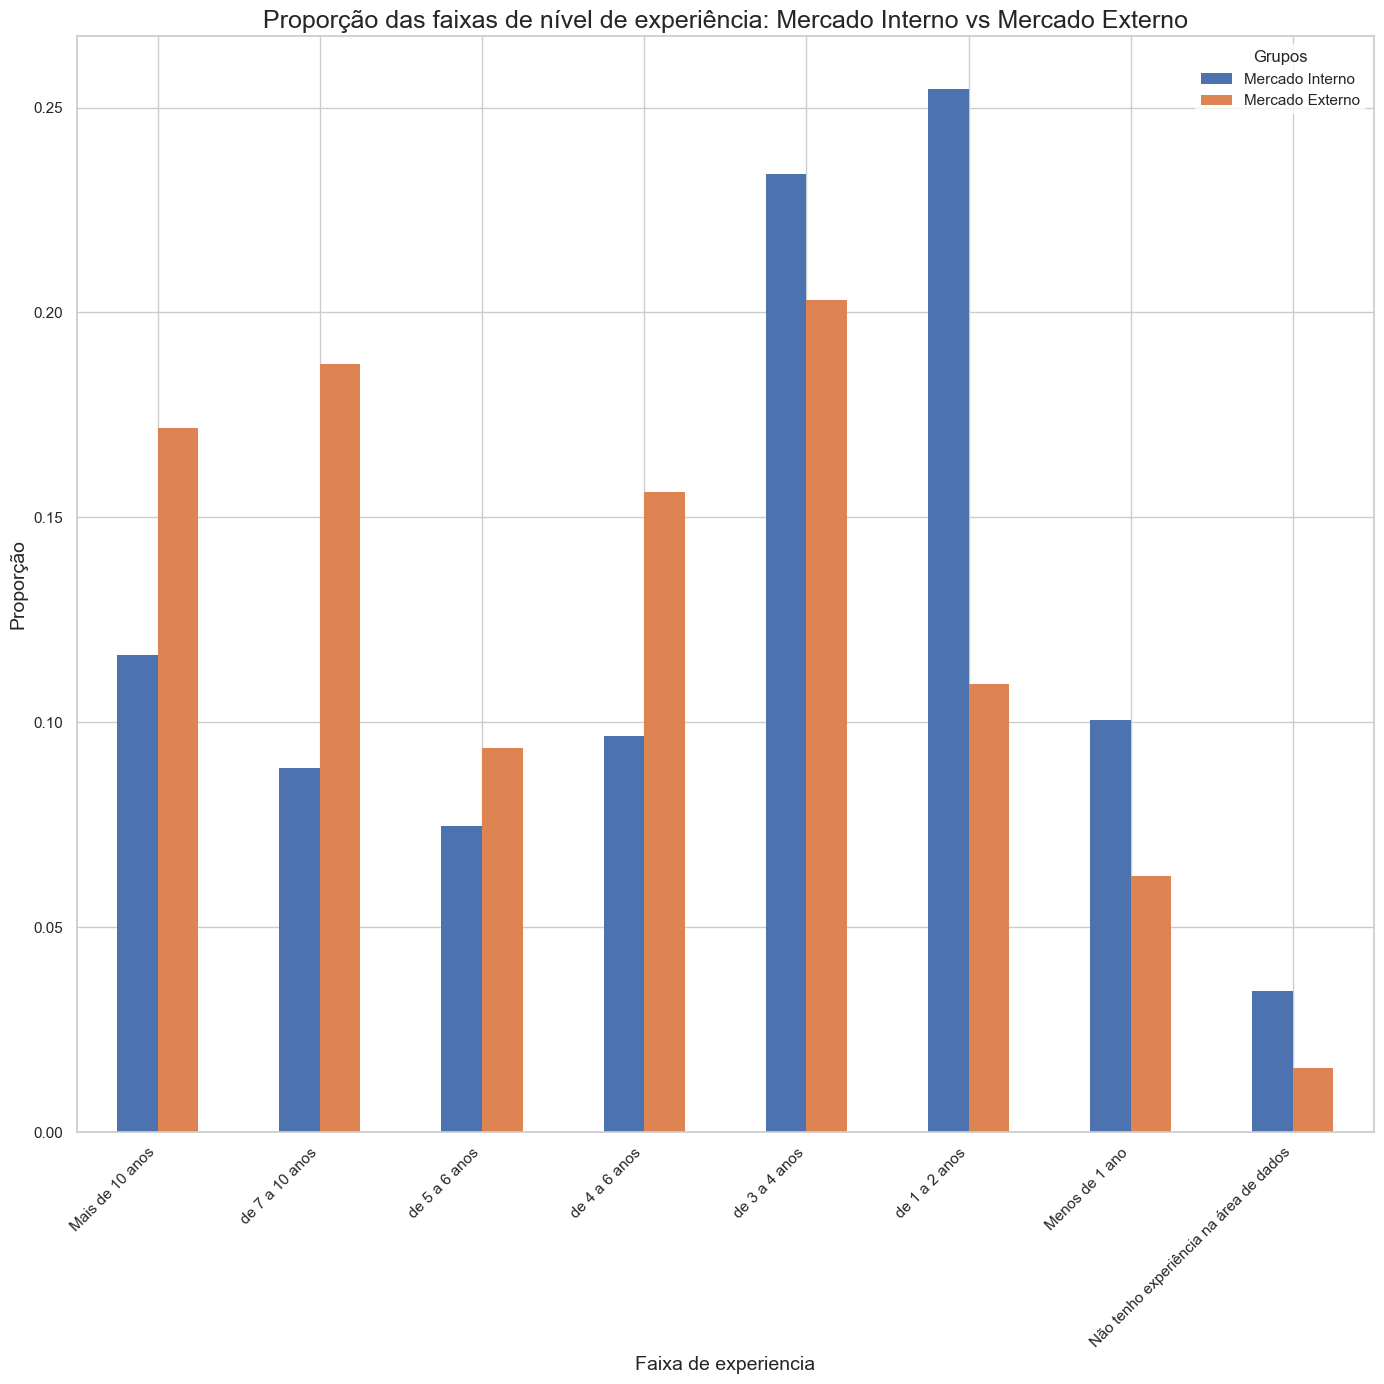

In [9]:
# Plota a proporção de cada faixa de nível de experiência para ambos os grupos
merged_df[["Proportion_Domestic", "Proportion_Abroad"]].plot(kind="bar", figsize=(14, 14))
plt.title("Proporção das faixas de nível de experiência: Mercado Interno vs Mercado Externo")
plt.xlabel("Faixa de experiencia")
plt.ylabel("Proporção")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Grupos", labels=["Mercado Interno", "Mercado Externo"])
plt.savefig(OUTPUT_GRAPH+"experiencia_mercado_interno_vs_externo.png")
plt.tight_layout()
plt.show()

# 3 - Visão DA

In [10]:
# Criar df apenas de analistas de dados
df_targets = df_work[df_work["P2_f Cargo Atual"] == "Analista de Dados/Data Analyst"]
# Dropar colunas com 100% de valores nulos
df_targets = df_targets.dropna(axis=1, how='all')
df_targets.shape

(907, 260)

In [11]:
# Criar df de analistas de dados + outros cargos que podem ocupar a mesma vaga
df_targets_ext = df_work[df_work["P2_f Cargo Atual"].isin(["Analista de Dados/Data Analyst", "Analista de BI/BI Analyst", "Cientista de Dados/Data Scientist"])]
# Dropar colunas com 100% de valores nulos
df_targets = df_targets.dropna(axis=1, how='all')
df_targets_ext.shape

(2100, 279)

## 3.1 - Pergunta 12: Qual a faixa salarial por senioridade de analistas e cientistas de dados?

In [12]:
# Remove cargo de BI Analyst pois não é o foco da pergunta, seleciona as colunas de interesse e agrupa por cargo, nível e faixa salarial. O método size() conta o número de ocorrências de cada combinação de cargo, nível e faixa salarial e o método unstack() reorganiza os dados para que as faixas salariais se tornem colunas
grouped_data = df_targets_ext[~df_targets_ext["P2_f Cargo Atual"].isin(["Analista de BI/BI Analyst"])][["P0 id", "P2_f Cargo Atual", "P2_g Nivel", "P2_h Faixa salarial"]].groupby(["P2_f Cargo Atual", "P2_g Nivel", "P2_h Faixa salarial"]).size().unstack(fill_value=0)


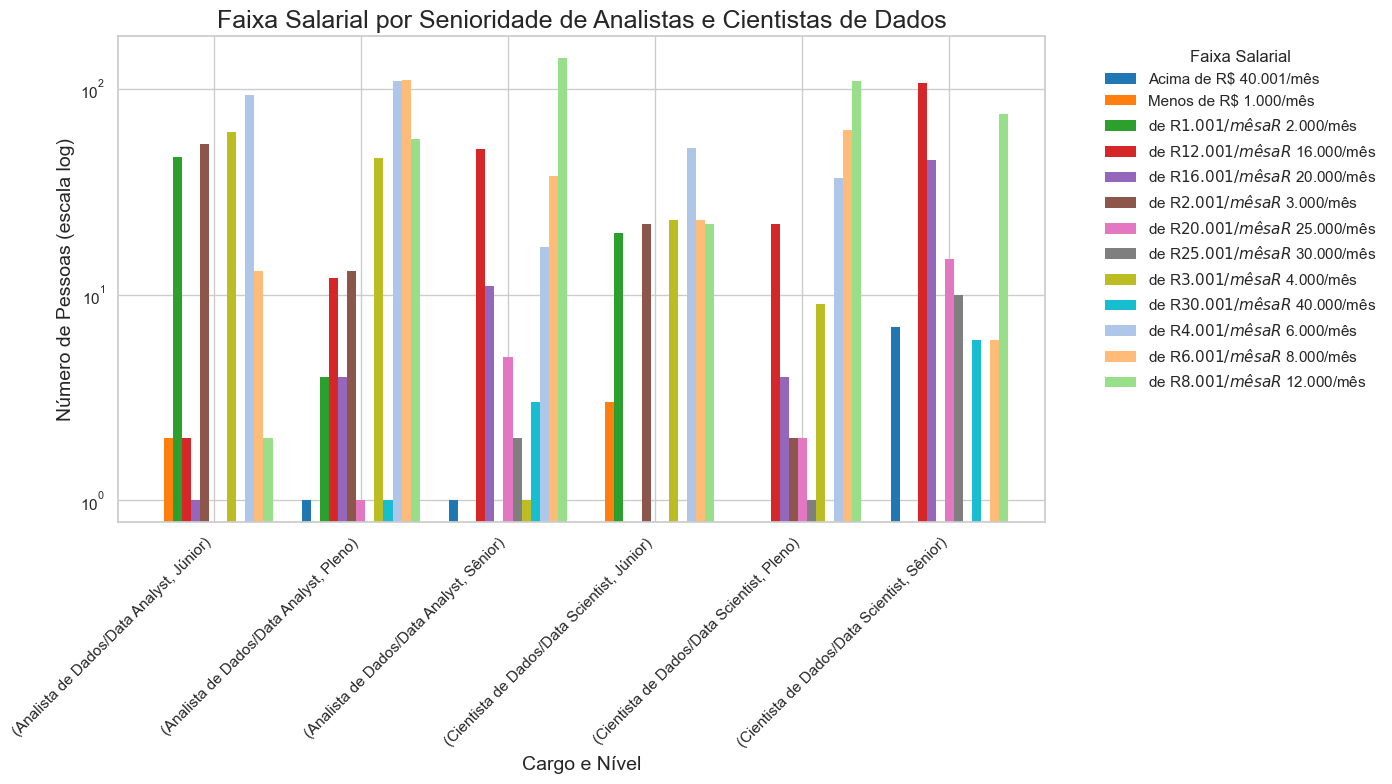

In [13]:
# Plotar o gráfico de barras empilhadas
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#aec7e8", "#ffbb78", "#98df8a"]
fig = grouped_data.plot(kind="bar", figsize=(14, 8), color=colors, width=0.8)
plt.title("Faixa Salarial por Senioridade de Analistas e Cientistas de Dados")
plt.xlabel("Cargo e Nível")
plt.ylabel("Número de Pessoas (escala log)")
# Transforma a escala do eixo y em logaritmo para melhor visualização (diminui a diferença de tamanho entre as barras muito pequenas e as muito grandes)
fig.set_yscale("log")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Faixa Salarial", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(OUTPUT_GRAPH+"bar_faixa_salario.png")
plt.show()

## 4.2 - Visão gestores

In [14]:
# Criar dataset apenas de gestores
df_heads = df_work[df_work["P2_d Gestor?"] == 1.0]
df_heads = df_heads.dropna(axis=1, how='all')
df_heads.shape

(896, 70)

# 5 - Exportar DataFrames

In [15]:
# Exportar dataframes para .csv
df_targets.to_csv(OUTPUT_CSV+"data_dataAnalysts.csv", index=False)
df_targets_ext.to_csv(OUTPUT_CSV+"data_dataAnalysts_ext.csv", index=False)
df_heads.to_csv(OUTPUT_CSV+"data_gestores.csv", index=False)